In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from xml.etree import ElementTree as et
import glob
import cv2
import torch 


boxes = []
labels =[]
for xml in glob.glob('C:/Personal/projects/RoadCrackDetection/Dataset/potholes/*.xml'):
    tree = et.parse(xml)
    root = tree.getroot()
    for member in root.findall('object'):
        labels.append(member.find('name').text)
        xmin = int(member.find('bndbox').find('xmin').text)
        xmax = int(member.find('bndbox').find('xmax').text)
        ymin = int(member.find('bndbox').find('ymin').text)
        ymax = int(member.find('bndbox').find('ymax').text)
        if (ymax <= ymin):
            print(xmin,xmax,ymin,ymax)
print(cv2.imread('C:/Personal/projects/RoadCrackDetection/Dataset/potholes/1.jpg').shape)
print(np.unique(labels))

BATCH_SIZE = 8
RESIZE_TO =768
NUM_EPOCHS = 50

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
TRAIN_DIR = "C:\\Personal\\projects\\RoadCrackDetection\\Dataset\\potholes"

CLASSES = [
    'background','crack' ,'damage' ,'pothole' ,'pothole_water' ,'pothole_water_m'
]
NUM_CLASSES = 6

VISUALIZE_TRANSFORMED_IMAGES = False
OUT_DIR = "C:/Personal/projects/RoadCrackDetection/Dataset/OUTPUTS"
SAVE_PLOTS_EPOCH = 1
SAVE_MODELS_EPOCH = 1


c:\Users\hariv\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(768, 1024, 3)
['crack' 'damage' 'pothole' 'pothole_water' 'pothole_water_m']


In [4]:
import albumentations as A
import cv2 
import numpy as np
from albumentations.pytorch import ToTensorV2

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

def collate_fn(batch):
    return tuple(zip(*batch))

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

def show_tranformed_image(train_loader):
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box in boxes:
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
            plt.imshow(sample)
            plt.title('Transformed Image')
            plt.show()


In [5]:
import numpy as np 
from mean_average_precision import MetricBuilder
def get_batch_mAP(outputs,targets):
    metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=NUM_CLASSES)
    for b in range(len(outputs)):
        preds = []
        for i in range(len(outputs[b]['boxes'])):
            bboxes = outputs[b]['boxes'][i].tolist()
            label = outputs[b]['labels'][i].tolist()
            score = outputs[b]['scores'][i].tolist()
            pred = bboxes + [label,score]
            preds.append(pred)
        preds = np.array(preds)
        
        gts = []
        for i in range(len(targets[b]['boxes'])):
            bboxes = targets[b]['boxes'][i].tolist()
            label = targets[b]['labels'][i].tolist()
            crowd = targets[b]['iscrowd'][i].tolist()
            gt = bboxes + [label,0,crowd]
            gts.append(gt)
        gts = np.array(gts)
        
        metric_fn.add(preds, gts)   
    voc_pascal_map = metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']
    voc_pascal_map_allpts = metric_fn.value(iou_thresholds=0.5)['mAP']
    coco_map = metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']
    return voc_pascal_map,voc_pascal_map_allpts,coco_map

In [6]:
import torch
import cv2
import numpy as np
import os
import glob as glob

from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader,Dataset,random_split
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch.optim as optim
import torchvision.models as models

class PotholeDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        # read the image
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        # convert BGR to RGB color format
        image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_path.replace('jpg','xml')
        annot_file_path = annot_filename
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            ymax_final = (ymax/image_height)*self.height
            
            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

In [7]:
# prepare the final datasets and data loaders
train_data = PotholeDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
# valid_dataset = TrashDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
valid_size=0.2
train_size=1-valid_size
num_train=len(train_data)
split=int(np.floor(valid_size*num_train))
train_dataset, val_dataset = random_split(train_data, (num_train-split,split))
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}\n")

Number of training samples: 400
Number of validation samples: 100



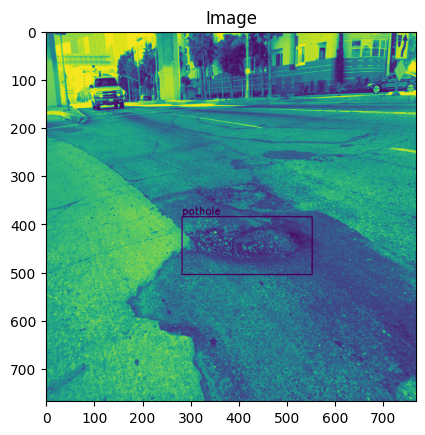

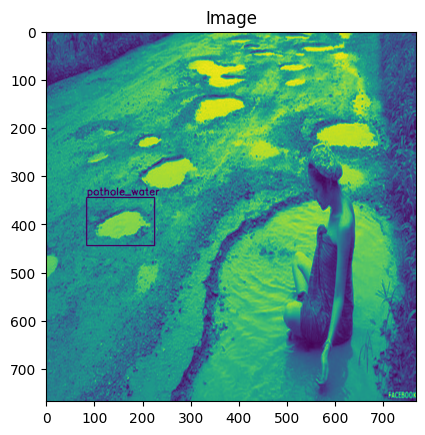

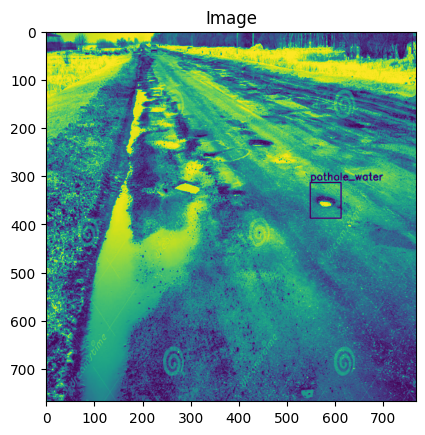

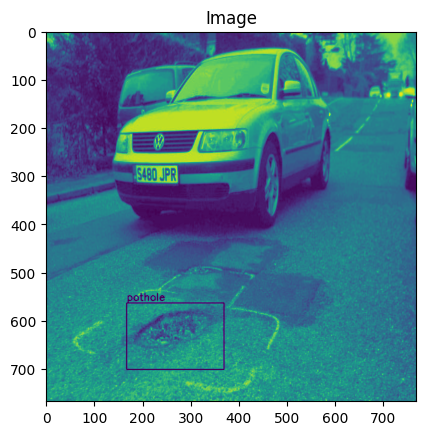

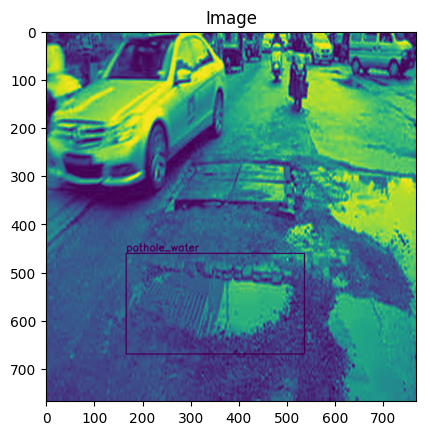

In [8]:
dataset = PotholeDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO , CLASSES)
def visualize_sample(image, target):
    box = target['boxes'][0]
    label = CLASSES[target['labels'][0]]
    cv2.rectangle(
        image, 
        (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
        (0, 255, 0), 2
    )
    cv2.putText(
        image, label, (int(box[0]), int(box[1]-5)), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
    )
    plt.imshow(image)
    plt.title('Image')
    plt.show()

for i in range(5):
    img,tar=dataset[i]
    visualize_sample(img,tar)

In [43]:
# model
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [55]:
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
import time

plt.style.use('ggplot')
# function for running training iterations
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        desc= ""
        for key,value in loss_dict.items():
            desc+=f"{key}: {value:.4f} "
        losses = sum(loss for loss in loss_dict.values())
        
        loss_value = losses.item()
        train_loss_list.append(loss_value)

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        train_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=desc+f"Loss: {loss_value:.4f}")
    return train_loss_list

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
#             print(targets)
            loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)

        val_loss_hist.send(loss_value)

        val_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [56]:
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

In [57]:
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# name to save the trained model with
MODEL_NAME = 'model'

# whether to show transformed images from data loader or not
if VISUALIZE_TRANSFORMED_IMAGES:
    from utils import show_tranformed_image
    show_tranformed_image(train_loader)


EPOCH 1 of 50
Training


  0%|          | 0/50 [00:00<?, ?it/s]


ValueError: axes don't match array

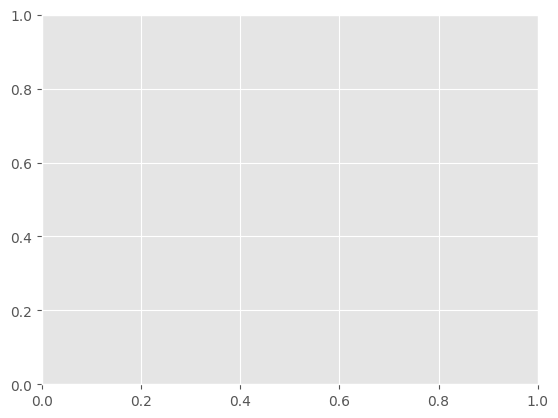

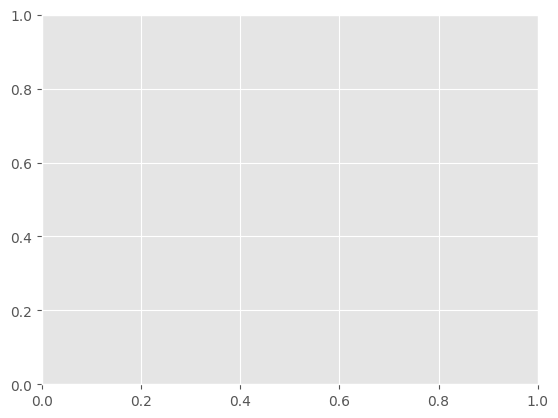

In [58]:
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")   
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')

    if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # save loss plots after n epochs
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...')

    if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")

        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")

    plt.close('all')
    # sleep for 5 seconds after each epoch
    time.sleep(5)
    